In [ ]:
import numpy as np
import pandas as pd
import os


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

100%|██████████| 429M/429M [00:09<00:00, 46.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


In [ ]:
# Set the path to your RAVDESS dataset directory
DATA_PATH = "/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1"  # Replace with your dataset path

# Prepare lists to store file paths and emotion labels
file_paths = []
emotions = []

# Extract file paths and labels from the dataset directory
for root, _, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith(".wav"):
            file_paths.append(os.path.join(root, file))
            # Extract emotion from file name format (for RAVDESS)
            emotion = int(file.split('-')[2])
            emotions.append(emotion)

In [ ]:
# Map RAVDESS emotion labels to emotion names
emotion_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fearful',
    7: 'disgust',
    8: 'surprised'
}

# Convert emotion numbers to names
emotion_labels = [emotion_map[e] for e in emotions]


In [ ]:
import librosa

# Function to extract features from audio files
def extract_features(file_path):
    # Load audio file
    audio, sample_rate = librosa.load(file_path, sr=None)

    # Extract audio features
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
    zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y=audio))

    # Concatenate features
    return np.concatenate([mfccs, chroma, spectral_contrast, [zero_crossing]])

# Extract features for all files
features = [extract_features(file_path) for file_path in file_paths]

# Create a DataFrame with features and labels
data_df = pd.DataFrame(features)
data_df['emotion'] = emotion_labels


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode labels
label_encoder = LabelEncoder()
data_df['emotion'] = label_encoder.fit_transform(data_df['emotion'])

# Split data
X = data_df.iloc[:, :-1].values  # Feature columns
y = to_categorical(data_df['emotion'].values)  # One-hot encoded labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

# Build the model
model = Sequential([
    Conv1D(64, kernel_size=3, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(128, return_sequences=False),  # LSTM layer for sequence processing
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(y_train.shape[1], activation="softmax")  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 60, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,616 (455.53 KB)

 Trainable params: 116,616 (455.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Reshape data for Conv1D input
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.1267 - loss: 2.0877 - val_accuracy: 0.1528 - val_loss: 2.0455
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.1709 - loss: 2.0193 - val_accuracy: 0.2899 - val_loss: 1.9308
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.2279 - loss: 1.9409 - val_accuracy: 0.2899 - val_loss: 1.9032
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.2426 - loss: 1.9358 - val_accuracy: 0.3212 - val_loss: 1.8210
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2941 - loss: 1.8462 - val_accuracy: 0.3351 - val_loss: 1.7877
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.2858 - loss: 1.8309 - val_accuracy: 0.3438 - val_loss: 1.7292
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.3067 - loss: 1.8079 - val_accuracy: 0.3663 - val_loss: 1.7195
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3118 - loss: 1.7740 - val_accuracy: 0.3576 - v

In [ ]:
# Evaluate model performance
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6669 - loss: 0.8591
Test Accuracy: 67.88%


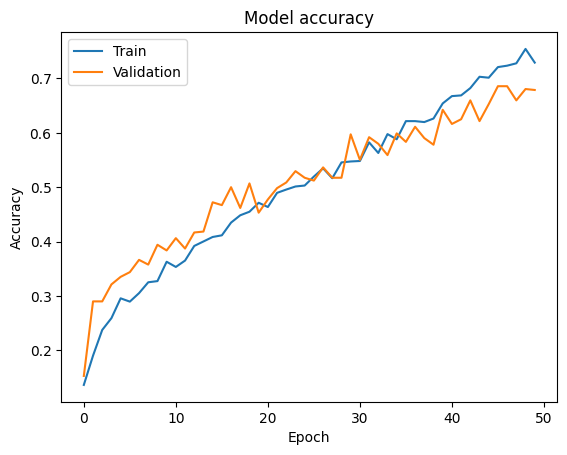

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save("emotion_recognition_model.h5")
